In [1]:
import pandas as pd
import numpy as np
import os
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from wordcloud import WordCloud
from collections import defaultdict
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

sns.set()
STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datalore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
TWEET_DIR = '/data/workspace_files/Random Tweets'
OUTPUT_DIR = '/data/workspace_files/Twitter Datasets'

### Twitter Dataset Compilation - Random Tweets

This notebook contains our compilation of the Random Tweet Twitter dataset. In the **RoBERTa Sentiment Scoring** notebook, we predict sentiment scores for each tweet included in this dataset. This notebook also includes a comprehensive EDA for the tweets obtained and a word cloud of illustrating the most frequently occuring words in the dataset.

First, we load the data.

In [3]:
tweet_files = os.listdir(TWEET_DIR)
print('Directory contains {} files'.format(len(tweet_files)))

Directory contains 67 files


In [4]:
dtypes = {
    'id': str,
    'author_id': str,
    'text': str
}
use_cols = ['id', 'author_id', 'created_at', 'text']
data = []

for file in tweet_files:
    try:
        df = pd.read_csv(os.path.join(TWEET_DIR, file), usecols=use_cols,
                         dtype=dtypes, lineterminator='\n')
        df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    except KeyError:
        print('Problem with file: {}'.format(file))
        continue

    # drop records where the date is NaT
    df.dropna(subset=['created_at'], inplace=True)

    # drop the meta data columns as they are values as of the date pulled
    # not the date of the text (also reorders the columns)
    df = df.loc[:, use_cols]
    
    data.append(df)

data = pd.concat(data, axis=0, ignore_index=True)

Next, we apply Twitter specific preprocessing so that the tweets can be fed to the RoBERTa model. See the `clean_text` function below for details on all the steps. Please note that cleaning all 4.8 million tweets takes approximately 1 hour.

In [5]:

def clean_text(text, demojize=True):
    """
    Data cleaning for Twitter RoBERTa model:
    https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
    Most text preprocessing is handled by the pretrained models'
    tokenize function, so we just do Twitter specific parsing here.
    """
    # remove new lines
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')

    # identify retweets and parse out the retweet start
    if text.startswith('RT @'):
        try:
            text = re.findall('RT \@\S+ (.+)', text, flags=re.DOTALL)[0]
        except IndexError:
            # could not parse the retweet
            # currently only one of these so, we don't print the warning
            # print('Could not parse potential retweet: {}'.format(text))
            pass

    # remove all # symbols as they represent hashtags which shouldn't 
    # have any predictive power
    text = re.sub('#', ' ', text)

    # there are a lot of different emojis, well over 150
    # rather than add emojis as separate tokens for the model,
    # we can replace the emoji with its descriptive text, which 
    # should already be a token in any pretrained model(s)
    if demojize:
        text = emoji.demojize(text, delimiters=(' ', ' '))

    # quite a few tweets have links to external content; e.g., https://t.co/AVDxyTcSb9
    # these also shouldn't have any predictive power, so we replace them
    # with 'http' so that 'http' can be added as a special token
    # for a pretrained model
    # http is used in the pre-trained Twitter RoBERTa model
    text = re.sub('https://\S+\s*', ' http ', text)

    # many tweets include Twitter handles (e.g., other Twitter accounts)
    # we replace these with '@user' so that '@user' can be added as 
    # a special token for a pretrained model
    # @user is used in the pre-trained Twitter RoBERTa model
    text = re.sub('@[A-Za-z0-9_]+', ' @user ', text)

    # replace multiple sequential instances of '@user' with a single
    # '@user' token
    # there are a lot of tweets with 3+ handles in a row and the number of 
    # handles probably isn't that informative
    text = re.sub('(\s*\@user\s*){2,}', ' @user ', text)

    # replace multiple spaces with single spaces
    text = text.replace('\s+', ' ')

    return text

In [6]:
%%time
data['clean_text'] = data['text'].map(clean_text)

CPU times: user 54min 18s, sys: 1.19 s, total: 54min 19s
Wall time: 54min 21s


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4829265 entries, 0 to 4829264
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   author_id   object        
 2   created_at  datetime64[ns]
 3   text        object        
 4   clean_text  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 184.2+ MB


In [8]:
data.head(10)

,id,author_id,created_at,text,clean_text
0,880954010085322752,879691869206302720,2017-07-01 00:59:37,Be part of the newest Pump n Dump Group!\n\nht...,Be part of the newest Pump n Dump Group! htt...
1,880954003189780480,38553323,2017-07-01 00:59:36,Excited for the @AetherUnited crowdsale! Their...,Excited for the @user crowdsale! Their crowd...
2,880953935611219968,872651826570637312,2017-07-01 00:59:20,#ANS $8.83\n0.0035709 BTC\nBid ☞ 0.00357028 BT...,ANS $8.83 0.0035709 BTC Bid ☞ 0.00357028 BTC ...
3,880953852278841344,2678078618,2017-07-01 00:59:00,Winkdex Bitcoin price changed -0.50% to $2435....,Winkdex Bitcoin price changed -0.50% to $2435....
4,880953757986697217,2281314234,2017-07-01 00:58:37,What Caused the #ethereum Price Crash This Wee...,What Caused the ethereum Price Crash This Wee...
5,880953664084598784,713341326801182721,2017-07-01 00:58:15,#Adzcoin News is out : https://t.co/3lsOxKXFpZ...,Adzcoin News is out : http Thanks to @user b...
6,880953643008217092,2276587183,2017-07-01 00:58:10,If your idea doesn't get merged into Core or a...,If your idea doesn't get merged into Core or a...
7,880953597311111168,54792391,2017-07-01 00:57:59,Is it worth mining ethereum in the San Francis...,Is it worth mining ethereum in the San Francis...
8,880953575060504577,4328945173,2017-07-01 00:57:54,[updt] Re: New Moderator member to help you on...,[updt] Re: New Moderator member to help you on...
9,880953430751277058,872651826570637312,2017-07-01 00:57:19,#ANS $8.75\n0.00354 BTC\nBid ☞ 0.00353784 BTC\...,ANS $8.75 0.00354 BTC Bid ☞ 0.00353784 BTC As...


We look at a variety of summary statistics for the tweet data to better understand the contents and determine whether any data should be removed.

In [9]:
# some summary statistics around the tweet data
print('Potentially Truncated Tweets: {:.0f}'.format(data['clean_text'].str.contains('…').sum()))
print('Number of Retweets:           {:.0f}'.format(data['text'].str.startswith('RT @').sum()))
print('Max Tweets Per Author:        {:.0f}'.format(data['author_id'].value_counts().max()))
print('Min Tweets Per Author:        {:.0f}'.format(data['author_id'].value_counts().min()))

tweet_lens = data['text'].map(lambda x: len(x))
print('\nOriginal Tweets')
print('Mean Tweet Length:            {:.0f}'.format(tweet_lens.mean()))
print('Median Tweet Length:          {:.0f}'.format(tweet_lens.median()))
print('Max Tweet Length:             {:.0f}'.format(tweet_lens.max()))
print('Min Tweet Length:             {:.0f}'.format(tweet_lens.min()))

def clean_tween_len(text):
    # replace the @user and http strings with a single character
    # so they are only counted once
    text = text.replace('@user', 'H')
    text = text.replace('http', 'L')
    text = text.replace('\s+', ' ')

    return len(text)

clean_tweet_lens = data['clean_text'].map(clean_tween_len)
print('\nClean Tweets')
print('Mean Tweet Length:            {:.0f}'.format(clean_tweet_lens.mean()))
print('Median Tweet Length:          {:.0f}'.format(clean_tweet_lens.median()))
print('Max Tweet Length:             {:.0f}'.format(clean_tweet_lens.max()))
print('Min Tweet Length:             {:.0f}'.format(clean_tweet_lens.min()))

print('\nClean Tweets, Length >500:    {:.0f}'.format((clean_tweet_lens > 500).sum()))
print('Clean Tweets, Length < 15:    {:.0f}'.format((clean_tweet_lens < 15).sum()))

Potentially Truncated Tweets: 192619
Number of Retweets:           14713
Max Tweets Per Author:        87675
Min Tweets Per Author:        1

Original Tweets
Mean Tweet Length:            157
Median Tweet Length:          137
Max Tweet Length:             501
Min Tweet Length:             9

Clean Tweets
Mean Tweet Length:            137
Median Tweet Length:          114
Max Tweet Length:             5722
Min Tweet Length:             9

Clean Tweets, Length >500:    1769
Clean Tweets, Length < 15:    869


Some tweets contain the "…" character, which seems to indicate that the tweet has been truncated; there are approximately 200 thousand tweets like this. We do not apply any specific cleaning steps to these tweets as, from our investigation, they still appear to contain relevant information. Interestingly, there is also one account in the data that has over 85 thousand tweets over the five and a half year period. We noticed several bot like accounts in the data, so this is probably one of them.

Next we explore the distribution of tweet lengths as there appears to be a few very long and very short tweets in the data.

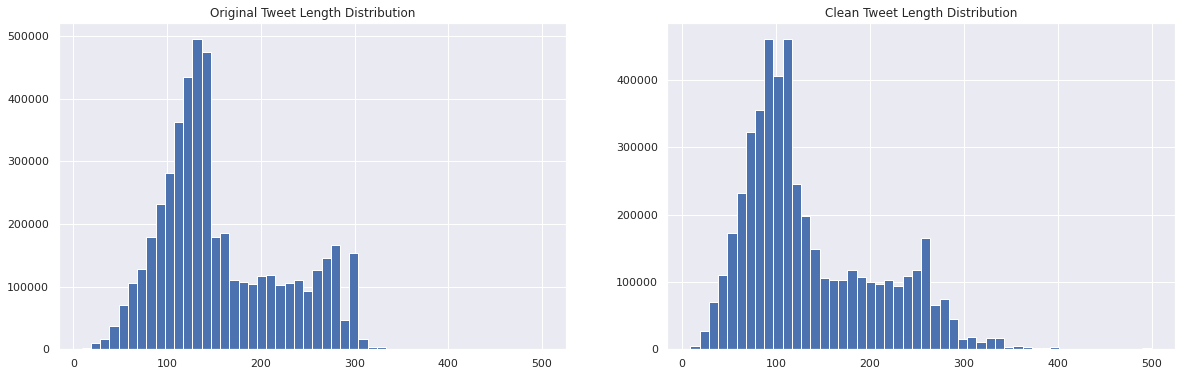

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].hist(tweet_lens, bins=50)
ax[0].set_title('Original Tweet Length Distribution')

# truncate the max length to 500 so we don't see as long of a tail
# for the clean tweets
hist_lens = clean_tweet_lens.copy()
hist_lens[hist_lens > 500] = 500
ax[1].hist(hist_lens, bins=50)
ax[1].set_title('Clean Tweet Length Distribution')

plt.show()

The mode of the tweet length distribution is around 140, which was the original tweet character limit. This limit was increased to 280, which is why we see some longer tweets. There are a some tweets that are longer than the 280 character limit, but this is relatively rare. Also, in the original tweet text, emojis count as a single character; however, when we expand emojis during the text cleaning process (see above), the number of characters in the tweet increases.

We sample some of very long and very short tweets in the data below. Many of the very long tweets include many, many emojis that significantly increase the length of the tweet once expanded. Many of of the very short tweets are just a few words followed by a link.

In [11]:
data.loc[clean_tweet_lens > 500, :].head(10)

,id,author_id,created_at,text,clean_text
63718,890586513792258048,171745655,2017-07-27 14:55:45,"""BCC is the original"" 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂...","""BCC is the original"" face_with_tears_of_joy ..."
74896,1156820473138810881,968796006576947200,2019-08-01 06:54:28,"BitMEX $BTC Whale:\n$10,000,000 worth of #Bitc...","BitMEX $BTC Whale: $10,000,000 worth of Bitco..."
74897,1156820455367565314,968796006576947200,2019-08-01 06:54:23,"BitMEX $BTC Whale:\n$10,000,000 worth of #Bitc...","BitMEX $BTC Whale: $10,000,000 worth of Bitco..."
76078,1157002354207711232,1089277200266858497,2019-08-01 18:57:11,"In every Shape and Form, Polaris Universal Lt...","In every Shape and Form, Polaris Universal Lt..."
77305,1157181767272607744,968796006576947200,2019-08-02 06:50:07,"BitMEX $BTC Whale:\n$7,600,000 worth of #Bitco...","BitMEX $BTC Whale: $7,600,000 worth of Bitcoi..."
84035,1158209503869001728,968796006576947200,2019-08-05 02:53:58,"BitMEX $BTC Whale:\n$8,950,958 worth of #Bitco...","BitMEX $BTC Whale: $8,950,958 worth of Bitcoi..."
85017,1158360319804235777,968796006576947200,2019-08-05 12:53:16,"BitMEX $BTC Whale:\n$9,670,195 worth of #Bitco...","BitMEX $BTC Whale: $9,670,195 worth of Bitcoi..."
92620,1159524061522698241,4769892366,2019-08-08 17:57:33,Dollar Dollar bill ya'll 💵💵💵 💵💵💵💵💵💵💵💵💵\nHappy ...,Dollar Dollar bill ya'll dollar_banknote dol...
93170,1159597755402248193,968796006576947200,2019-08-08 22:50:23,"BitMEX $BTC Whale:\n$9,246,590 worth of #Bitco...","BitMEX $BTC Whale: $9,246,590 worth of Bitcoi..."
115606,1163042232951349248,731910716849000449,2019-08-18 10:57:31,moon soon $btc #bitcoin 5 days\n\n🥵🥵\n🥵🥵🥵\n 🥵...,moon soon $btc bitcoin 5 days hot_face hot...


In [12]:
data.loc[clean_tweet_lens < 15, :].head(10)

,id,author_id,created_at,text,clean_text
22755,884396546187550722,855509561561755648,2017-07-10 12:59:02,Flat. #bitcoin,Flat. bitcoin
27242,885076170961813505,3091467942,2017-07-12 09:59:37,#BTC bitt,BTC bitt
37735,886660630161141760,50041415,2017-07-16 18:55:42,BTFD #BTC,BTFD BTC
51530,888743213833605120,867750331412774916,2017-07-22 12:51:08,#btc\nMY LOVE,btc MY LOVE
54659,889210563703603200,3332397178,2017-07-23 19:48:13,#BTC Coin https://t.co/jdC0B86FOz,BTC Coin http
66586,891024840114806784,105240593,2017-07-28 19:57:30,2 vaut #eth,2 vaut eth
69792,891507328381530113,36307315,2017-07-30 03:54:45,#Eth upside 8%,Eth upside 8%
72187,891869396699828224,92425195,2017-07-31 03:53:28,#BTC SHORT 40K,BTC SHORT 40K
74205,892170650789400576,845315478159527941,2017-07-31 23:50:33,10 Mins!! #BTC,10 Mins!! BTC
77325,1157181117205602305,904792333950099459,2019-08-02 06:47:32,Nice pop #eth,Nice pop eth


In [13]:
# drop clean tweets of length >500
# these are tweets with LOTS of emojis
# when translating emojis to text, the size of the tweets grows significantly
# also drop clean tweets of length <15 (counting @user and http as one character)
# these are mostly one word tweets or tweets that are just a link
# see above for some examples
drop_idx = data.index[(clean_tweet_lens > 500) | (clean_tweet_lens < 15)]
data.drop(drop_idx, axis=0, inplace=True)

print('Remaining Tweets: {}'.format(data.shape[0]))

Remaining Tweets: 4826627


We decide to drop the approximately two thousand very long and very short tweets as there are relatively few of these and it removes some of the noise in the data. We plot the final number of cleaned tweets per day and authors per day in the Random Tweet dataset (image is used in the report).

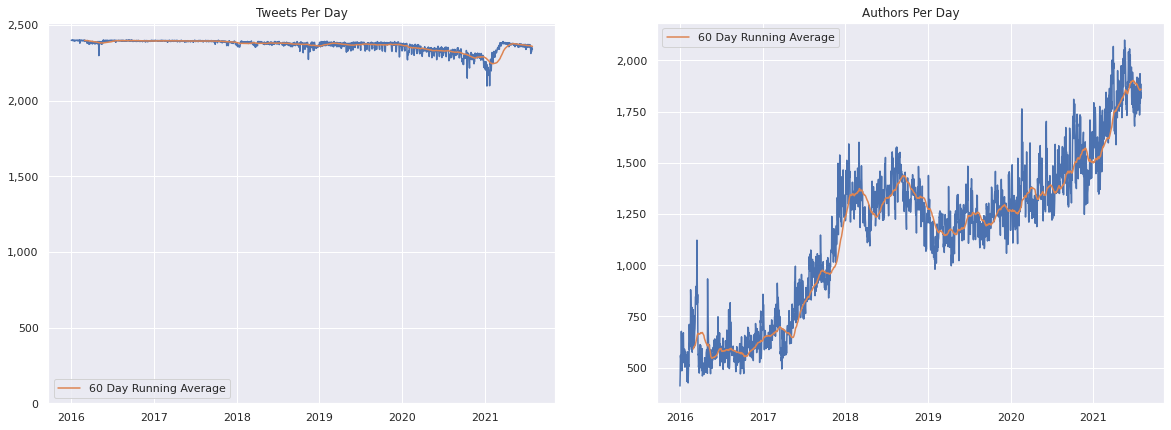

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

tweets_per_day = data.groupby(pd.Grouper(key='created_at', freq='D'))['id'].count()
authors_per_day = data.groupby(pd.Grouper(key='created_at', freq='D'))['author_id'].nunique()

window = 60

ax[0].plot(tweets_per_day)
ax[1].plot(authors_per_day)

ax[0].plot(tweets_per_day.rolling(window).mean(), label='{} Day Running Average'.format(window))
ax[1].plot(authors_per_day.rolling(window).mean(), label='{} Day Running Average'.format(window))
ax[0].legend(loc='lower left')
ax[1].legend(loc='upper left')

ax[0].set_title('Tweets Per Day')
ax[1].set_title('Authors Per Day')

# format the y-axis
ax[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
ax[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 

# set y-axis so it starts at 0
y_low, y_high = ax[0].get_ylim()
ax[0].set_ylim((0.0, y_high + 100))

# save for the report
fig.savefig('rand_tweet_dist.png')
plt.show()

Finally, we do one last check of the data and save the dataset with the cleaned tweets.

In [15]:
print('Days with 0 tweets: {}'.format(tweets_per_day.resample('D').asfreq().isna().sum()))

Days with 0 tweets: 0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4826627 entries, 0 to 4829264
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   author_id   object        
 2   created_at  datetime64[ns]
 3   text        object        
 4   clean_text  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 220.9+ MB


In [17]:
data.head()

,id,author_id,created_at,text,clean_text
0,880954010085322752,879691869206302720,2017-07-01 00:59:37,Be part of the newest Pump n Dump Group!\n\nht...,Be part of the newest Pump n Dump Group! htt...
1,880954003189780480,38553323,2017-07-01 00:59:36,Excited for the @AetherUnited crowdsale! Their...,Excited for the @user crowdsale! Their crowd...
2,880953935611219968,872651826570637312,2017-07-01 00:59:20,#ANS $8.83\n0.0035709 BTC\nBid ☞ 0.00357028 BT...,ANS $8.83 0.0035709 BTC Bid ☞ 0.00357028 BTC ...
3,880953852278841344,2678078618,2017-07-01 00:59:00,Winkdex Bitcoin price changed -0.50% to $2435....,Winkdex Bitcoin price changed -0.50% to $2435....
4,880953757986697217,2281314234,2017-07-01 00:58:37,What Caused the #ethereum Price Crash This Wee...,What Caused the ethereum Price Crash This Wee...


In [22]:
# drop the original text column 
# \r and \n in the text cause a lot of problems when saving 
# the data to csv
original_text = data['text']  # save original text for word cloud below
data.drop(['text'], axis=1, inplace=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4826627 entries, 0 to 4829264
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   author_id   object        
 2   created_at  datetime64[ns]
 3   clean_text  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 184.1+ MB


In [20]:
data.to_csv(os.path.join(OUTPUT_DIR, 'twitter_dataset_random.csv'), 
            index=False, encoding='utf-8')

In this next section, we create a word cloud for the Random Tweet dataset that helps us visualize the contents of the data by presenting the most frequently occuring words. The final image generated is included in the report. Note that the placement of words varies from run to tun for some reason (haven't looked into why), but the size of each word is consistent.

In [24]:
def decontracted(phrase):
    """
    Un-do contractions. For example, "won't" becomes "will not",
    "he's" becomes "he is", etc. There are some issues as 
    "Tom's" becomes "Tom is" even though this is a possessive 
    noun, but this isn't an issue for purposes of the word cloud.
    """
    # from https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

def word_cloud_counts(texts):
    """Create the word frequency dict used to generate the word cloud."""
    word_counts = defaultdict(lambda: 0)
    
    for text in texts:
        # twitter parsing 
        # we replace emojis with text as the wordcloud library 
        # requires additional code/dependencies to use plot emojis
        text = clean_text(text)
        
        # basic text parsing
        text = text.lower()
        text = decontracted(text)
        text = re.sub(r'[^0-9a-z\s]+', ' ', text)

        # tokenize each word
        word_list = re.findall('(?u)\\b\\w\\w+\\b', text)
        # remove stop words
        word_list = [word for word in word_list if word not in STOP_WORDS]

        for word in word_list:
            word_counts[word] += 1

    return word_counts

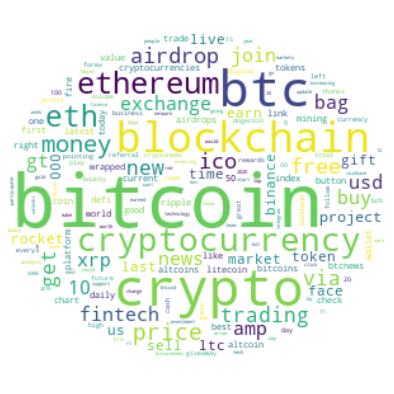

In [25]:
# create the word cloud!
# this takes like 1 hour...
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

word_counts = word_cloud_counts(original_text)
# link and handle are tokens added in the Twitter parsing
# we remove these as they have very common but don't provide
# content specific information
word_counts.pop('user')
word_counts.pop('http')

# ellipse shape
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 / 1.2 ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color='white', mask=mask)
wc.generate_from_frequencies(word_counts)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

# save for the report
fig.savefig('word_cloud_rand.png')
plt.show()